In [ ]:
#| default_exp s2a_delar_mup_wds
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import io
import time
import math
import random
import dataclasses

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from fastcore.basics import store_attr
from huggingface_hub import hf_hub_download

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import webdataset as wds

In [ ]:
#| export
from whisperspeech.train import *
from whisperspeech.modules import *
from whisperspeech import vq_stoks

In [ ]:
from IPython.display import Audio, HTML, display

# Semantic to acoustic token modeling

Multi-GPU training example:

    python3 -m whisperspeech.train_multi \
        --task "s2a_delar_mup_wds small --quantizers 2 --frozen_embeddings_model vqmodel-256c-dim64-4e-hyptuned-32gpu.model" \
        --input-dir "whisperspeech-s2a-512c-dim64/*.tar.gz 125000 --stoks_pad_token=512" \
        --batch-size 12 --epochs 4 \
        --tunables=--rope

### Load the dataset

In [ ]:
#| exporti
def rand(start, end):
    return random.random() * (end - start) + start

In [ ]:
#| exporti
def random_trunc(random_trunc_p, atoks_len = 2250, stoks_len = 750):
    atoks_per_second = atoks_len / 30
    def _trunc(samples):
        for s in samples:
            if random.random() < random_trunc_p:
                seconds = rand(0.3, 30)
                s['atoks.npy'] = s['atoks.npy'][:,:math.ceil(seconds * atoks_per_second)]
            s['stoks.npy'] = s['stoks.npy'][:math.ceil(s['atoks.npy'].shape[-1]/atoks_len*stoks_len)]
            yield s
    return _trunc

def pad_samples(atoks_len = 2250, stoks_len = 750, stoks_pad_token = 4096):
    def _pad(samples):
        for s in samples:
            s['stoks.npy'] = F.pad(torch.tensor(s['stoks.npy']), (0, stoks_len - s['stoks.npy'].shape[-1]), value=stoks_pad_token)
            s['atoks.npy'] = F.pad(torch.tensor(s['atoks.npy']), (0, atoks_len - s['atoks.npy'].shape[-1]), value=-100)
            yield s
    return _pad

In [ ]:
#| exporti
def speaker_id_extractor(speaker_map):
    def _extractor(samples):
        for s in samples:
            s['speaker'] = torch.tensor(speaker_map[s['__key__'].split("/")[1]])
            yield s
    return _extractor

In [ ]:
shards = [str(x) for x in Path('s2a-6454/').glob('*.tar.gz')]

In [ ]:
ds = wds.WebDataset(wds.ResampledShards(shards)).compose(
    wds.decode(),
    speaker_id_extractor({'6454': 0}),
)

In [ ]:
for s in ds: break
s

{'__key__': 'large/6454/bishops_secret_1309_librivox_64kb_mp3/bishopssecret_10_hume_64kb_008',
 '__url__': 's2a-6454/000174.tar.gz',
 'stoks.npy': array([ 467,  995,   45,  196, 1540, 3162, 3303, 3348, 3098, 3098, 1720,
         668,  165, 3253, 3558, 3864, 3202, 1332, 3992, 3992,  515,  423,
          49, 1120,  966, 3074, 1214, 1875,  976,  369,  320, 3657, 2676,
        2621, 3521, 2964,  807, 3324, 3324, 2009, 1329, 1329,  805, 1512,
        1512, 2394, 2559, 2152,  326, 2877, 2620, 1103, 1357, 3428, 4088,
         568, 3313, 2100, 3257,  952, 3430, 4024, 1280,  320, 3184,  210,
         130, 2483, 2972, 4084, 3435,  388,  388, 1159, 1590, 1590, 1095,
        1289,  956,  839, 2999,  540, 2115, 1339, 3416, 3138, 2114, 1040,
        2872, 1013, 3513, 3324, 3324,  602, 3529, 3529,  614, 2018, 3803,
        1740, 1671, 3788, 3770,  323,  323,  323, 2673, 3547,   30,   30,
        2507, 2507,   45, 3477,  687,  481, 2115, 3823, 3823, 2933,  663,
         565,  565,  179, 3357, 3173, 34

In [ ]:
#| export
def load_datasets(
        input:str,             # webdataset folder
        samples:int,           # samples per epoch
        subsample:float=1,     # use a fraction of the files
        val_samples:int=512,
        random_trunc_p:float=0,# probability of truncating the input to less than 30 seconds
        stoks_pad_token=4096,
    ):

    if isinstance(input, (Path, str)):
        path = Path(input)
        if path.is_dir():
            glob = '*-s2a-*.tar.gz'
        else:
            glob = path.name
            path = path.parent
        input = Path(path).glob(glob)
    elif isinstance(input, list):
        pass
    else:
        raise ArgumentError("input should be either a list or a path with an optional glob specifier")
    shards = [str(x) for x in input]

    speakers = set()
    for shard in shards:
        with open(shard+'.speakers.txt') as f: speakers = speakers.union(set(x.strip() for x in f.readlines()))
    speakers = {id:i for i,id in enumerate(sorted(speakers))}

    def ds(shards, length):
        ds = wds.WebDataset(wds.ResampledShards(shards)).compose(
            wds.decode(),
            speaker_id_extractor(speakers),
            random_trunc(random_trunc_p) if random_trunc_p > 0 else lambda x: x,
            pad_samples(stoks_pad_token=stoks_pad_token),
            wds.to_tuple('stoks.npy', 'atoks.npy', 'speaker'),
            wds.batched(64),
        )
        ds.speakers = speakers
        ds.total_samples = length
        return ds.compose(wds.slice(length // 64)).with_epoch(length // 64).with_length(length // 64)
    
    return (
        ds(shards[1:], samples),
        ds(shards[:1], val_samples),
    )

In [ ]:
train_ds, val_ds = load_datasets('/data/whisperspeech/whisperspeech-s2a/', samples=16500000)

In [ ]:
train_ds.speakers

{'100': 0,
 '10001': 1,
 '10002': 2,
 '10006': 3,
 '1001': 4,
 '10010': 5,
 '10013': 6,
 '10016': 7,
 '10017': 8,
 '10018': 9,
 '10020': 10,
 '10021': 11,
 '10022': 12,
 '10023': 13,
 '10025': 14,
 '10027': 15,
 '10029': 16,
 '10031': 17,
 '10033': 18,
 '10036': 19,
 '10038': 20,
 '1004': 21,
 '10040': 22,
 '10041': 23,
 '10043': 24,
 '10044': 25,
 '10045': 26,
 '10046': 27,
 '10048': 28,
 '10050': 29,
 '10052': 30,
 '10054': 31,
 '10056': 32,
 '10057': 33,
 '10059': 34,
 '1006': 35,
 '10061': 36,
 '10062': 37,
 '10064': 38,
 '10066': 39,
 '10068': 40,
 '10069': 41,
 '1007': 42,
 '10070': 43,
 '10071': 44,
 '10072': 45,
 '10073': 46,
 '10074': 47,
 '10075': 48,
 '10076': 49,
 '10078': 50,
 '10079': 51,
 '10082': 52,
 '10084': 53,
 '10085': 54,
 '10087': 55,
 '10088': 56,
 '10089': 57,
 '10091': 58,
 '10092': 59,
 '10093': 60,
 '10095': 61,
 '10096': 62,
 '10097': 63,
 '10099': 64,
 '10100': 65,
 '10101': 66,
 '10102': 67,
 '10104': 68,
 '10106': 69,
 '10107': 70,
 '10108': 71,
 '10110'

In [ ]:
train_ds, val_ds = load_datasets('s2a-6454-4q/*.tar.gz', samples=160000)

In [ ]:
train_ds.speakers

{'6454': 0}

In [ ]:
for stoks, atoks, spk in progress_bar(val_ds.unbatched(), total=2): pass

### Sanity check the dataloader

In [ ]:
from whisperspeech.vq_stoks import RQBottleneckTransformer
from whisperspeech.a2wav import Vocoder

In [ ]:
vqmodel = RQBottleneckTransformer.load_model(local_filename='vqmodel-4e-hyptuned-32gpu.model').cuda()
vocoder = Vocoder()

In [ ]:
atoks[:,:(atoks==-100).nonzero()[0,1]]

tensor([[658, 502, 868,  ..., 408, 408, 408],
        [364,  46, 371,  ..., 518, 913, 913],
        [270, 489, 489,  ...,  36, 937, 937],
        [616, 701, 352,  ..., 739, 741, 673]], dtype=torch.int16)

In [ ]:
stoks[stoks != vqmodel.vq_codes]

tensor([2643,  479, 1720,  590, 1565, 2514, 2514, 1459, 1448,  777, 3286, 1808,
        1395,  210, 1792, 3521, 3109,  921,  921, 2337, 2337, 2337,  781, 2807,
         753, 3195,  198, 2690, 2190,  857,  714,  817, 3963,  629, 3975, 3009,
        1634, 3078, 3940,  503,  950, 3869, 1406,  400, 1364,  393,  393, 2390,
        3953, 1556,  652, 2439,  804, 2018, 3639, 4041, 4041,  239, 2922, 3940,
        2275, 1693, 1785,  656, 2938, 4024, 2915, 2300, 1671, 2859, 4022, 3366,
        1344, 1344, 2547,  233, 3587, 1657, 3209,  789, 1574, 2685, 3132,  921,
         921, 3276,  970, 2584, 1833, 2520, 3973, 1155, 2923, 3841, 1736, 2508,
        3009, 1428,  331, 3340, 3340, 1568, 3904, 1594, 1733, 2520, 3973, 2708,
        1384, 2585, 3724, 3681,  389, 1330, 2683, 1846, 3790,  886,  886, 2165,
        3332,  271, 3869,  906,  286, 3069, 3165, 2459, 2459,   78, 3058, 1418,
         640, 2699, 2890, 1364,  393,  393,  393,  940,   29,   29, 3953, 1314,
        2902, 2238, 2841, 2152,   39, 16

In [ ]:
vocoder.decode_to_notebook(torch.tensor(atoks[:,:(atoks==-100).nonzero()[0,1]]).cuda())
vqmodel.decode_text(torch.tensor(stoks[stoks != 4096]))[0].text

'but rather to the entrance hall and corridors. As you enter, you come at once into a hall, long enough and high enough, to suit any second-sized gothic dome.'

In [ ]:
# btw. text decoding works well even from the middle of the segment
vqmodel.decode_text(torch.tensor(stoks[150:]))[0].text

'long enough and high enough to suit any second-sized gothic dome.'

### Check acoustic token entropy

In [ ]:
from collections import Counter

In [ ]:
cnt = Counter()
for stoks, atoks, spks in val_ds:
    cnt.update(atoks[:,0,:].reshape(-1).tolist())
pdf = {k:x/cnt.total() for k,x in cnt.items()}
pdf

{475: 0.012936631944444445,
 835: 0.009018229166666667,
 738: 0.009128472222222222,
 408: 0.026542534722222223,
 779: 0.008802083333333334,
 276: 0.005439236111111111,
 777: 0.0012100694444444444,
 59: 0.0028602430555555555,
 804: 0.0012274305555555556,
 385: 0.0014340277777777778,
 1000: 0.0012265625,
 233: 0.0013845486111111111,
 358: 0.0005711805555555556,
 747: 0.003943576388888889,
 796: 0.0018541666666666667,
 921: 0.003717013888888889,
 203: 0.001703125,
 613: 0.003989583333333334,
 413: 0.0006319444444444444,
 402: 0.0025625,
 155: 0.0033003472222222223,
 457: 0.0049097222222222224,
 325: 0.002673611111111111,
 967: 0.004943576388888889,
 976: 0.004331597222222222,
 491: 0.008233506944444444,
 228: 0.004443576388888889,
 192: 0.002759548611111111,
 782: 0.0009817708333333334,
 588: 0.0008342013888888889,
 939: 0.0004782986111111111,
 912: 0.0025243055555555557,
 820: 0.0004592013888888889,
 808: 0.0018072916666666667,
 43: 0.001015625,
 372: 0.0008871527777777778,
 185: 0.00348

In [ ]:
-np.sum([1/1024*np.log(1/1024) for x in range(1024)])

6.931471805599454

In [ ]:
-np.sum([x*np.log(x) for x in pdf.values()])

4.459627075620794

## Model

In [ ]:
#| export
import pylab as plt
import fastprogress
import IPython
import numpy as np

class CMLMVisual:
    """Visualize training progress"""
    def __init__ (self, model, masterbar, total_steps):
        self.model = model
        self.masterbar = masterbar
        self.total_steps = total_steps
        self.epochs = total_steps // masterbar.main_bar.total
        
        gs = plt.GridSpec(3, 1, height_ratios=[2,2,1])
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.acc_p = graph_fig.add_subplot(gs[1], sharex=self.loss_p)
        self.acc_p.tick_params('x', labelbottom=False)
        self.lr_p = graph_fig.add_subplot(gs[2], sharex=self.loss_p)
        self.lr_p.tick_params('x', labelbottom=False)
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        self.acc = np.nan
        self.acc_history = []
        self.pacc_history = []
            
    def show(self):
        self.start_t = time.time()
        self.masterbar.write(["samples", "train", "val", "time"], table=True)
        self.graph_out = display(self.graph_fig, display_id=True)
        self.acc_out = display(IPython.display.HTML(''), display_id=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, acc_p, lr_p = self.loss_p, self.acc_p, self.lr_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        acc_p.clear()
        for k in self.acc_history[-1].keys():
            acc_p.plot(self.its, [x[k] for x in self.acc_history], ':')
#         acc_p.plot(self.its, np.stack(self.pacc_history), label=range(len(self.pacc_history[0])))
        lr_p.clear()
        lrs = np.array(self.lr_history)
        lr_p.plot(self.its, lrs)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        metrics = self.model.get_metrics()
        self.acc_history.append(metrics)
#         self.acc_out.update(f"Accuracy: {self.entropy_history[-1]:.2f}")
#         self.pacc_history.append((self.model.pval_true / self.model.pval_total).cpu().numpy())
#         if self.acc_history:
        html  = "<h5>Accuracies:</h5><table>"
        html += "<thead>"+(''.join([f"<td>{k}<td>" for k,x in metrics.items()]))+"</thead>"
        html += "<tr>"+(''.join([f"<td>{x*100:.1f}%<td>" for k,x in metrics.items()]))+"</tr>"
        html += "</table>"
        self.acc_out.update(IPython.display.HTML(html))
        self.plot()

    def add_table_row(self, it, avg_train_loss, val_loss):
        elapsed_t = time.time() - self.start_t
        self.masterbar.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)
    
    def on_iter(self, bar, it, avg_train_loss, val_loss):
        epoch = math.ceil(it / self.total_steps * self.epochs)
        bar.comment = f"#{epoch}/{self.epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f}"

In [ ]:
#| export
# modified from https://blog.eleuther.ai/rotary-embeddings/
import torch

class Rotary(torch.nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_dim=1):
        seq_len = x.shape[seq_dim]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(x.shape[seq_dim], device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]
        return self.cos_cached, self.sin_cached


# rotary pos emb helpers:
def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat(
        (-x2, x1), dim=-1
    )

#@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos[:,:q.shape[1]]) + (rotate_half(q) * sin[:,:q.shape[1]]), (k * cos) + (rotate_half(k) * sin)

In [ ]:
#| export
from torch import Tensor, nn
import torch.nn.functional as F
from typing import Dict, Iterable, Optional

class ResidualAttentionBlock(nn.Module):
    def __init__(self, n_state: int, n_head: int, cross_attention: bool = False, rope: bool = False,
                 qk_scale: float = 1, ffn_mult: int = 4):
        super().__init__()

        self.attn = MultiHeadAttention(n_state, n_head, qk_scale=qk_scale, rope=rope)
        self.attn_ln = LayerNorm(n_state)

        self.cross_attn = (
            MultiHeadAttention(n_state, n_head, qk_scale=qk_scale, rope=rope) if cross_attention else None
        )
        self.cross_attn_ln = LayerNorm(n_state) if cross_attention else None

        n_mlp = n_state * ffn_mult
        self.mlp = nn.Sequential(
            nn.Linear(n_state, n_mlp), nn.GELU(), nn.Linear(n_mlp, n_state)
        )
        self.mlp_ln = LayerNorm(n_state)
        
    def forward(
        self,
        x: Tensor,
        xa: Optional[Tensor] = None,
        causal = False,
        kv_cache: Optional[dict] = None,
    ):
        x = x + self.attn(self.attn_ln(x), causal=causal, kv_cache=kv_cache)[0]
        if self.cross_attn:
            x = x + self.cross_attn(self.cross_attn_ln(x), xa, kv_cache=kv_cache)[0]
        x = x + self.mlp(self.mlp_ln(x))
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, n_state: int, n_head: int, qk_scale: float = 1, rope: bool = False):
        super().__init__()
        self.n_head = n_head
        self.sqrt_qk_scale = math.sqrt(qk_scale)
        self.query = QueryHead(n_state, n_state)
        self.key = nn.Linear(n_state, n_state, bias=False)
        self.value = nn.Linear(n_state, n_state)
        self.out = nn.Linear(n_state, n_state)
        
        self.rotary = None
        if rope:
            self.rotary = Rotary(n_state // n_head)

    def forward(
        self,
        x: Tensor,
        xa: Optional[Tensor] = None,
        causal = False,
        kv_cache: Optional[dict] = None,
    ):
        q = self.query(x)

        if kv_cache is None or xa is None or self.key not in kv_cache:
            # hooks, if installed (i.e. kv_cache is not None), will prepend the cached kv tensors;
            # otherwise, perform key/value projections for self- or cross-attention as usual.
            k = self.key(x if xa is None else xa)
            v = self.value(x if xa is None else xa)
        else:
            # for cross-attention, calculate keys and values once and reuse in subsequent calls.
            k = kv_cache[self.key]
            v = kv_cache[self.value]

        if self.sqrt_qk_scale != 1:
            q *= self.sqrt_qk_scale
            k *= self.sqrt_qk_scale
        
        wv, qk = self.qkv_attention_pth20(q, k, v, causal)
#         wv, qk = self.qkv_attention_xformers(q, k, v, causal)
        
        return self.out(wv), qk

    def qkv_attention_pth20(
        self, q: Tensor, k: Tensor, v: Tensor, causal = False
    ):
        n_batch, n_ctx, n_state = q.shape
        q = q.view(*q.shape[:2], self.n_head, -1)
        k = k.view(*k.shape[:2], self.n_head, -1)
        v = v.view(*v.shape[:2], self.n_head, -1).permute(0, 2, 1, 3)
        
        #print('before rot:', q.shape, k.shape)
        if self.rotary:
            q, k = apply_rotary_pos_emb(q, k, *self.rotary(k))
        #print(' after rot:', q.shape, k.shape)

        k = k.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        # modified for better performance under PyTorch 2.0
        wv = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=0, is_causal=causal)

        # previously we've returned q@k which we don't have now
        # since it's not actually used anywhere else, let's just keep two return values for compatibility
        return wv.permute(0, 2, 1, 3).flatten(start_dim=2), None

    def qkv_attention_xformers(
        self, q: Tensor, k: Tensor, v: Tensor, causal = False
    ):
        n_batch, n_ctx, n_state = q.shape
        q = q.view(*q.shape[:2], self.n_head, -1)
        k = k.view(*k.shape[:2], self.n_head, -1)
        v = v.view(*v.shape[:2], self.n_head, -1)

        if self.rotary:
            q, k = apply_rotary_pos_emb(q, k, *self.rotary(k))

        bias = xops.LowerTriangularMask() if causal else None
        wv = xops.memory_efficient_attention(q,k,v, attn_bias=bias)

        # previously we've returned q@k which we don't have now
        # since it's not actually used anywhere else, let's just keep two return values for compatibility
        return wv.flatten(start_dim=2), None

In [ ]:
#| export
class DelSumDecoder(nn.Module):
    def __init__(self, depth=6, n_head=6, head_width=64, qk_scale=1, ffn_mult=4, length=2250, codes=1024, quantizers=8, linear_heads=True, rope=False, pos_embs=None):
        super().__init__()
        self.length = length
        width = n_head * head_width
        self.width = width
        self.codes = codes
        self.quantizers = quantizers
        self.linear_heads = linear_heads

        self.embeddings = nn.ModuleList([nn.Embedding(codes+1, width) for _ in range(quantizers)])
        if pos_embs is not None:
            self.register_buffer("positional_embedding", pos_embs)
        
        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale, ffn_mult=ffn_mult, cross_attention=True, rope=rope) for _ in range(math.floor(depth))
        ])

        self.ln_post = LayerNorm(width)

        if self.linear_heads:
            self.heads = LinearHead(width, (codes+1) * quantizers, bias=False)
        else:
            self.splitter = nn.Sequential(
                nn.Linear(width, width * quantizers),
                nn.GELU(),
            )
            self.heads = nn.ModuleList([
                LinearHead(width, codes+1, bias=True) for _ in range(quantizers)
            ])

    def forward(self, toks, xenc):
        b,_,n = toks.shape
        newn = min(n+1, self.length)
        embs = torch.zeros((b,newn,self.width), dtype=xenc.dtype, device=xenc.device)
        for i in range(self.quantizers):
            embs[:,:i+1] += self.embeddings[i](torch.tensor([self.codes], device=xenc.device))
            if i < n:
                embs[:,i+1:] += self.embeddings[i](toks[:,i,:newn-i-1])

        x = embs.to(xenc.dtype)
    
        for l in self.layers:
            x = l(x, xenc, causal=True)
        x = self.ln_post(x)

        if self.linear_heads:
            logits = self.heads(x).view(b,newn,self.quantizers,self.codes+1).permute(0,2,1,3)
        else:
            split = self.splitter(x).view(b,newn,self.quantizers,self.width)
            logits = torch.stack([self.heads[q](split[:,:,q]) for q in range(self.quantizers)], dim=1)

        return logits
    
class EmbeddingProjector(nn.Linear):
    pass

def rand(start, end):
    return random.random() * (end - start) + start
    
@dataclasses.dataclass
class Tunables:
    init_std :float = 9
    embeddings_std :float = 0.2
    embeddings_lr_scale: float = 10
    output_mult :float = 5.6
    # FIXME: try separate mults for self and cross attention
    query_mult :float = .3
    encoder_depth_ratio :float = 0.25
    linear_heads :bool = False
    rope :bool = True
    
    lr0 :float = 3e-3
    clip_gradient_norm :float = 2
    weight_decay :float = 1e-3
    warmup_steps :float = 2000

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 2*10**rand(0,1)
            self.embeddings_std = 10**rand(-1.7,-0.22)
            self.embeddings_lr_scale = 2**rand(2,4)
            self.output_mult = 2**rand(1.5,3)
            self.query_mult = 2**rand(-3,-1.3)
            self.encoder_depth_ratio = random.choice([0.25,0.5])
            self.linear_heads = False
            self.rope = True
            
            self.lr0 = 3e-3
            self.clip_gradient_norm = 10**rand(-1,1)
            self.warmup_steps = 100*(10**rand(1.18,1.3))
            
    @staticmethod
    def upgrade(args):
        args = {k:v for k,v in args.items()}
        def old_default(name, value):
            if name not in args: args[name] = value
        old_default('rope', False)
        old_default('linear_heads', True)
        return args
            
class SADelARTransformer(nn.Module):
    def __init__(self, depth=3, ctx_n=2250, stoks_len=750, stoks_codes=4097, stoks_width=None, spk_width=None, n_head=3, head_width=64, ffn_mult=4,
                 quantizers=8, speaker_map={"1":0}, tunables=Tunables()):
        super().__init__()
        self.quantizers = quantizers
        width = n_head * head_width
        store_attr("depth,ctx_n,stoks_len,stoks_codes,stoks_width,spk_width,n_head,head_width,ffn_mult,quantizers,speaker_map")
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        
        if stoks_width is None: stoks_width = width
        if spk_width is None: spk_width = width
        self.emb_factor = width != stoks_width
        self.spk_factor = width != spk_width

        if tunables.rope:
            self.positional_embeddings = None
        else:
            self.register_buffer('positional_embeddings', sinusoids(ctx_n, width))
        
        self.speaker_embedding = nn.Embedding(len(speaker_map), width)
        self.semantic_embedding = nn.Embedding(stoks_codes, stoks_width)
        if self.emb_factor:
            self.emb_to_hidden = nn.Linear(stoks_width, width)
        
        if self.spk_factor:
            self.spk_to_hidden = EmbeddingProjector(spk_width, width)

        qk_scale = self.tunables.query_mult * 8 / math.sqrt(head_width)
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        self.encoder = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale, ffn_mult=ffn_mult, rope=tunables.rope) for _ in range(encoder_depth)
        ])
        self.ln_post = LayerNorm(width)
        
        self.decoder = DelSumDecoder(pos_embs=self.positional_embeddings, qk_scale=qk_scale,
                                     length=ctx_n, n_head=n_head, head_width=head_width, ffn_mult=ffn_mult,
                                     depth=decoder_depth, quantizers=quantizers,
                                     linear_heads=tunables.linear_heads, rope=tunables.rope)

        self.register_buffer('val_true', torch.zeros(self.quantizers).cuda())
        self.register_buffer('val_total', torch.zeros(self.quantizers).cuda())
        self.apply(self.init_transformer)

    def setup(self, device):
        pass
        
    def load_frozen_semantic_embeddings(self, vqmodel):
        with torch.no_grad():
            self.semantic_embedding.weight[:] = vqmodel.rq.layers[0]._codebook.embed[0]
            self.semantic_embedding.lr_scale = 0
        
    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, EmbeddingProjector):
            m.lr_scale = self.tunables.embeddings_lr_scale/2
            std = self.tunables.init_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)

    def embed_stoks(self, Stoks):
        b,n = Stoks.shape
        if self.stoks_len == 1500:
            # converts 50 toks/s to 75 toks/s by adding padding between every two tokens
            x = Stoks.reshape(b,n//2,2)
            x = x.repeat_interleave(2, -1)[:,:,:3]
            x[:,:,1] = 1024
            x = x.reshape(b,n//2*3)
        else:
            # it's a lot easier with 25 toks/s
            x = Stoks.repeat_interleave(3, -1)
        # embed semantic tokens
        Sembs = self.semantic_embedding(x.to(torch.long))
        if self.emb_factor:
            Sembs = self.emb_to_hidden(Sembs)
        return Sembs

    def forward(self, Stoks, Atoks, speakers, noloss=False):
        Atoks = Atoks.to(torch.long)
        semb = self.embed_stoks(Stoks)
        with record_function("encoder"):
            if self.positional_embeddings is not None: semb = semb + self.positional_embeddings
            xenc = self.ln_post(self.encoder(semb))
#             xenc = torch.zeros_like(xenc)
        with record_function("decoder"):
            Atoks_gt = Atoks.clone()
            Atoks_gt[Atoks == -100] = 1024
            # we can randomize speaker ids during validation to measure
            # the importance of the speaker embedding vs. just the acoustic prompt/prefix
#             if not self.training: speakers = speakers[torch.randperm(speakers.nelement())]
            spk_embs = self.speaker_embedding(speakers)
            if self.spk_factor: spk_embs = self.spk_to_hidden(spk_embs)
            logits = self.decoder(Atoks_gt, xenc + spk_embs.unsqueeze(1))
            logits *= self.tunables.output_mult / (self.width / self.base_width)
            
        if noloss:
            return logits

        with record_function("loss"):
            N = Atoks.shape[-1]
            loss = 0
            for i in range(self.quantizers):
                loss += F.cross_entropy(logits[:,i,i:].reshape(-1,logits.shape[-1]), Atoks[:,i,:N-i].reshape(-1))
            loss /= self.quantizers

        if not self.training:
            for i in range(self.quantizers):
                Atoks_i = Atoks[:,i,:N-i]
                valid_Atoks = Atoks_i != -100
                self.val_true[i] += (logits[:,i,i:].argmax(-1)[valid_Atoks] == Atoks_i[valid_Atoks]).float().sum()
                self.val_total[i] += valid_Atoks.float().sum()

        return logits, loss

    def get_metrics(self):
        metrics = {
            f'acc_{i}':x.item() for i,x in enumerate(self.val_true / self.val_total)
        }
        self.val_true[:] = 0
        self.val_total[:] = 0
        return metrics

    #
    # inference
    #
    @classmethod
    def load_model(cls, repo_id="collabora/whisperspeech", filename="s2a_up_wds.model", local_filename=None):
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename)
        if '_extra_state' not in spec['state_dict']: spec['state_dict']['_extra_state'] = { 'speaker_map': spec['config']['speaker_map'] }
        model = cls(**spec['config'], tunables=Tunables(**Tunables.upgrade(spec['tunables'])))
        model.load_state_dict(spec['state_dict'])
        model.eval()
        return model
    
    def get_extra_state(self):
        return { 'speaker_map': self.speaker_map }
    
    def set_extra_state(self, st):
        self.speaker_map = st['speaker_map']

    def load_checkpoint(self, local_filename):
        spec = torch.load(local_filename, map_location='cpu')
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self
    
    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    @property
    def device(self):
        return next(self.parameters()).device
    
    @torch.no_grad()
    def generate(self, stoks, speakers, N=None, T=0.7, top_k=None, show_progress_bar=True):
        dev = self.device
        if self.stoks_len == 1500:
            N = N or len(stoks) * 3 // 2
        else:
            N = N or len(stoks) * 3
        stoks = F.pad(stoks.to(dev), (0, self.stoks_len - len(stoks)), value=self.stoks_codes-1).unsqueeze(0)
        speakers = torch.tensor([self.speaker_map[spk] for spk in speakers], device=dev)
        toks = torch.zeros((1,self.quantizers,N), dtype=torch.long, device=dev)
        it = range(0,N)
        if show_progress_bar: it = progress_bar(it)
        for i in it:
            p = self(stoks, toks[:,:,:i], speakers, noloss=True)
            last_p = p[0,:,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[:,-1,None]] = -torch.inf
            for j,tok in enumerate(torch.multinomial((last_p / float(T)).softmax(-1), 1)):
                toks[0,j,max(0,i-j)] = tok
            if toks[0,0,i] == 1024: return toks[0,:,:i]
        return toks[0]

In [ ]:
#| exporti
def _make_model(size:str, quantizers:int=4, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None, **kwargs):
    assert(dataset is not None)
    kwargs = dict(speaker_map=dataset.speakers, quantizers=quantizers, tunables=tunables, **kwargs)
    if size == 'micro':
        return SADelARTransformer(depth=4, n_head=3, ffn_mult=2, **kwargs)
    if size == 'tiny-narrow':
        return SADelARTransformer(depth=4, n_head=6, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return SADelARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return SADelARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'base-deep':
        return SADelARTransformer(depth=9, n_head=8, **kwargs)
    if size == 'base-wide':
        return SADelARTransformer(depth=6, n_head=12, **kwargs)
    if size == 'small/2':
        return SADelARTransformer(depth=9, n_head=12, **kwargs)
    if size == 'small':
        return SADelARTransformer(depth=12, n_head=12, **kwargs)
    if size == 'medium':
        return SADelARTransformer(depth=24, n_head=16, **kwargs)

def make_model(size:str, quantizers:int=4, frozen_embeddings_model:str=None, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None):
    if frozen_embeddings_model:
        vqmodel = vq_stoks.RQBottleneckTransformer.load_model(frozen_embeddings_model)
        model = _make_model(size, quantizers, tunables, dataset, stoks_codes=vqmodel.vq_codes+1, stoks_width=vqmodel.rq.layers[0]._codebook.embed[0].shape[-1])
        model.load_frozen_semantic_embeddings(vqmodel)
    else:
        model = _make_model(size, quantizers, tunables, dataset)
    return model

192 32 4097


samples,train,val,time
50016,3.43991,3.64125,03:15
100000,3.26612,3.39851,06:13
150016,3.15735,3.30149,09:10
160000,3.16834,3.29321,09:45


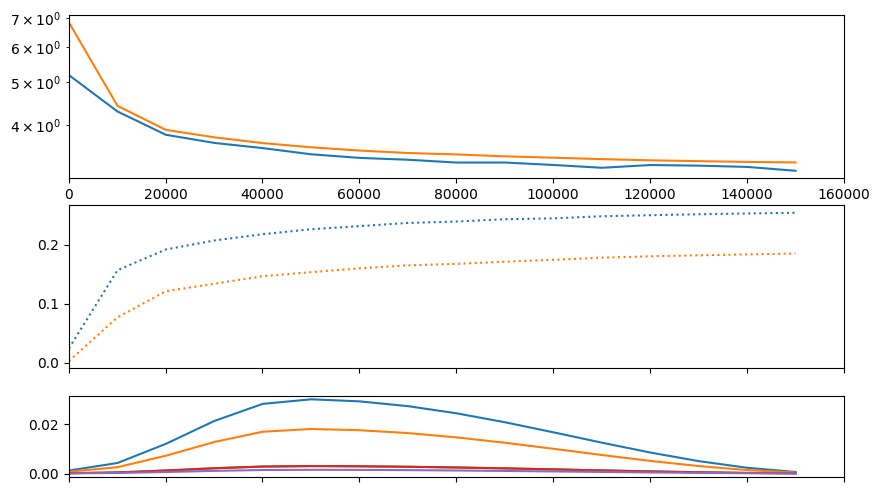

In [ ]:
# baseline
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.42783,3.63384,04:32
100000,3.24147,3.39155,08:49
150016,3.15337,3.29065,13:05
160000,3.17545,3.28113,13:56


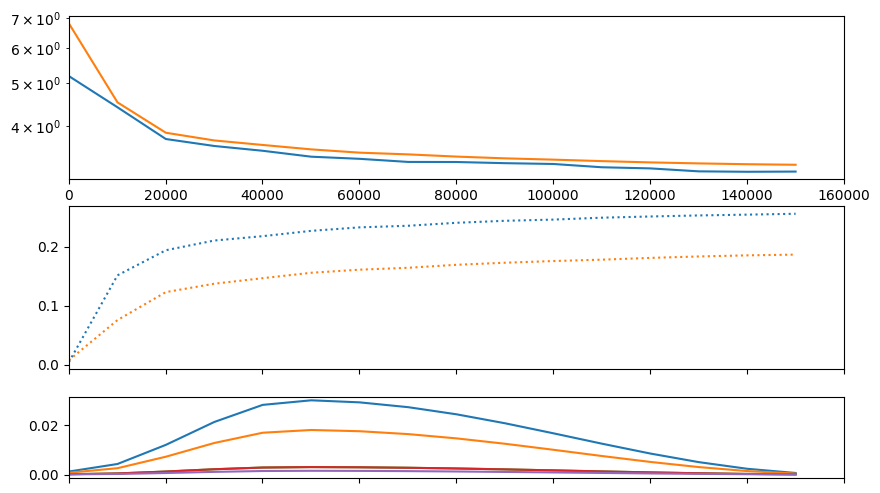

In [ ]:
# crossattn
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.30626,3.51887,03:17
100000,3.10474,3.23221,06:18
150016,3.00842,3.13535,09:18
160000,3.01038,3.12537,09:54


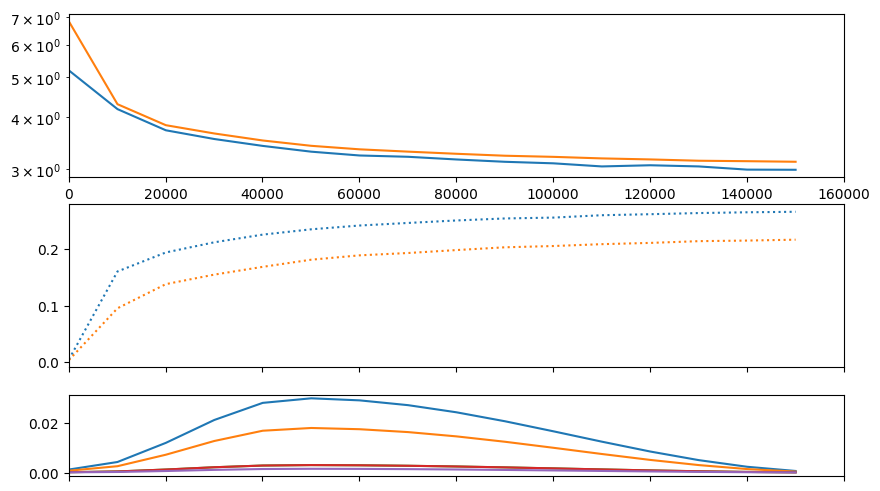

In [ ]:
# crossattn, emb 2Q
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.31771,3.37854,04:22
100000,3.11682,3.12633,08:44
150016,3.02503,3.01944,13:05
160000,3.01330,3.01079,13:58


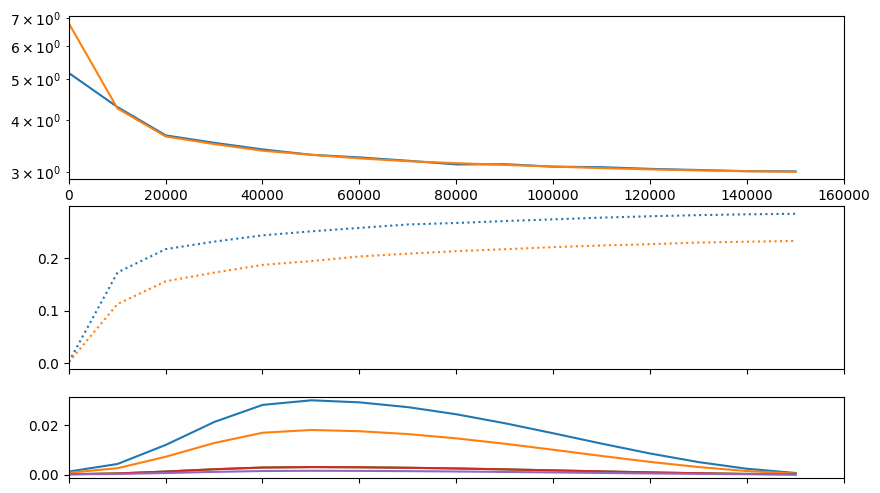

In [ ]:
# crossattn, emb 2Q, 400+ shards
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.06899,3.21095,04:24
100000,2.84990,2.93317,08:47
150016,2.77312,2.81134,13:10
180000,2.73082,2.77786,15:48


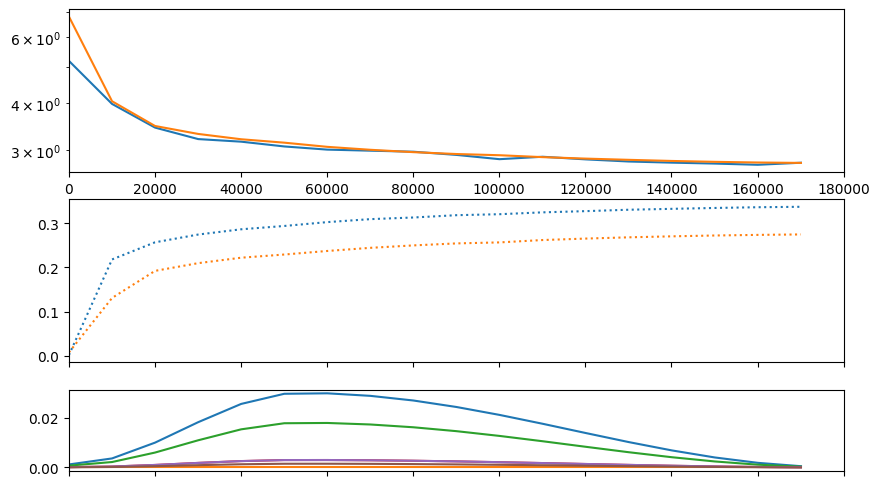

In [ ]:
# crossattn, emb 2Q, 400+ shards
train_ds, val_ds = load_datasets('s2a-small/*.tar.gz', samples=180000)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.10401,3.20805,04:24
100000,2.83302,2.92958,08:48
150016,2.75915,2.80805,13:12
180000,2.74166,2.77508,15:49


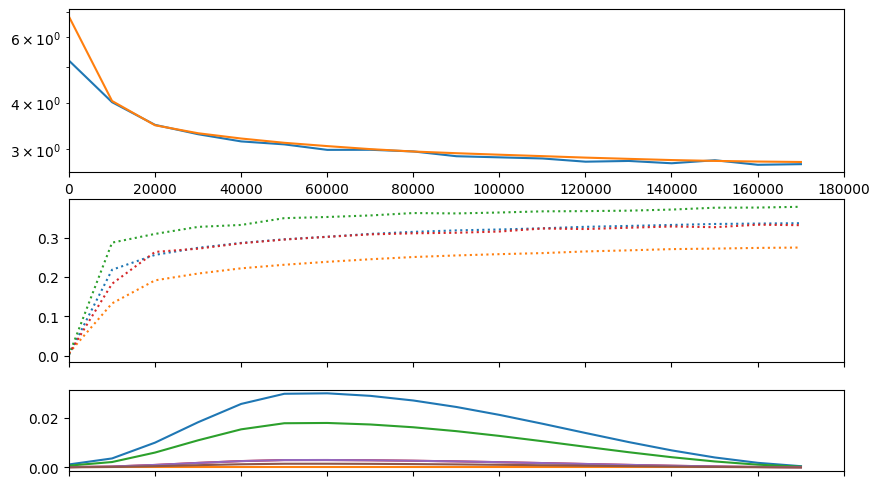

In [ ]:
# crossattn, emb 2Q, 400+ shards
train_ds, val_ds = load_datasets('s2a-small/*.tar.gz', samples=180000)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.04470,3.38566,04:23
100000,2.93321,3.15460,08:48
150016,2.76893,3.11252,13:13
180000,2.71715,3.10554,15:51


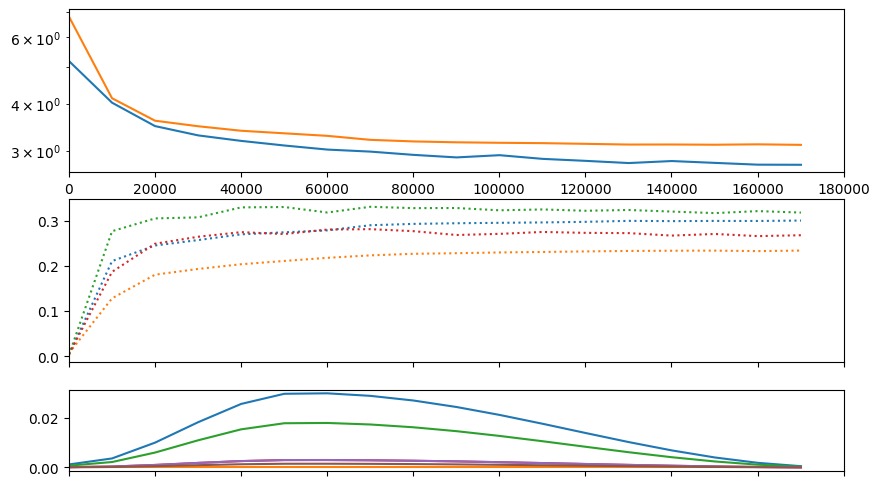

In [ ]:
# crossattn, emb 2Q, 400+ shards
train_ds, val_ds = load_datasets('s2a-small/*.tar.gz', samples=180000)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.08482,3.07243,03:55
100000,2.85717,2.89056,07:51
150016,2.79573,2.80195,11:46
160000,2.79021,2.79402,12:33


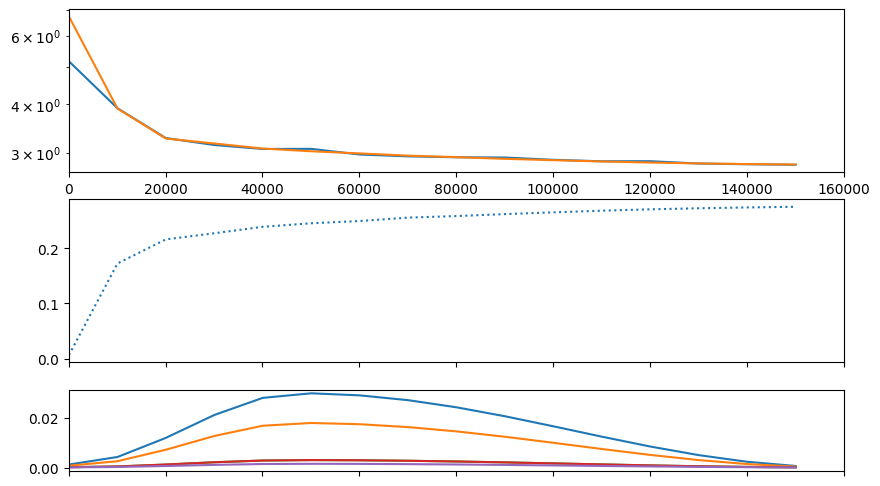

In [ ]:
# crossattn, emb all, 400+ shards
model = make_model('micro', quantizers=1, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.33196,3.38296,04:22
100000,3.10307,3.11948,08:44
150016,3.02954,3.01842,13:06
160000,2.97770,3.01012,13:58


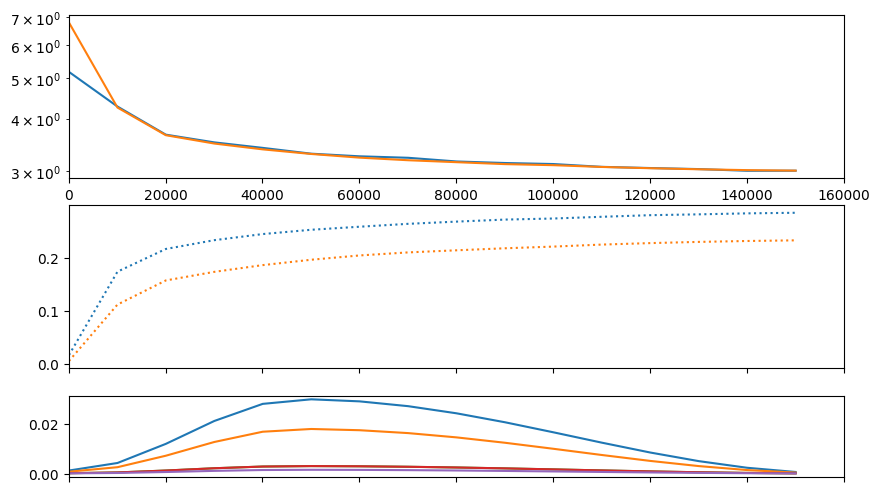

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.30979,3.40961,04:20
100000,3.10014,3.13427,08:39
150016,3.06509,3.03229,12:59
160000,3.05000,3.02330,13:51


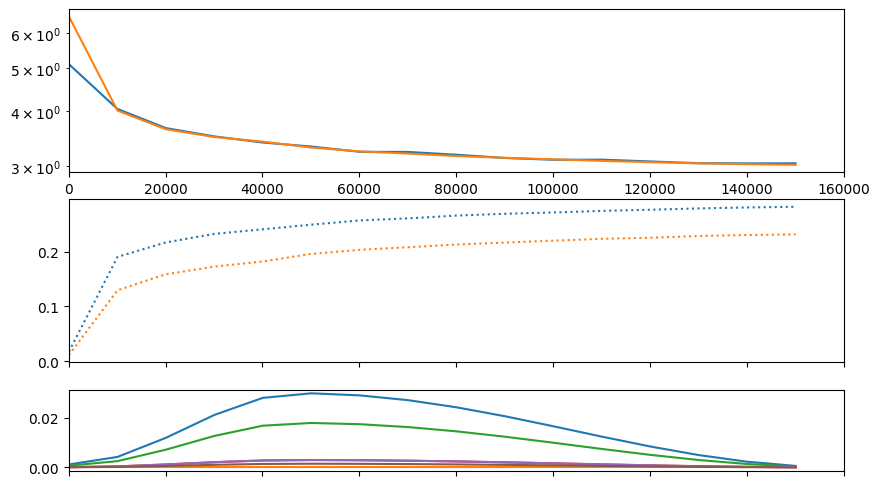

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.36395,3.41816,04:20
100000,3.10823,3.15187,08:39
150016,3.02961,3.04794,12:58
160000,3.05585,3.03891,13:50


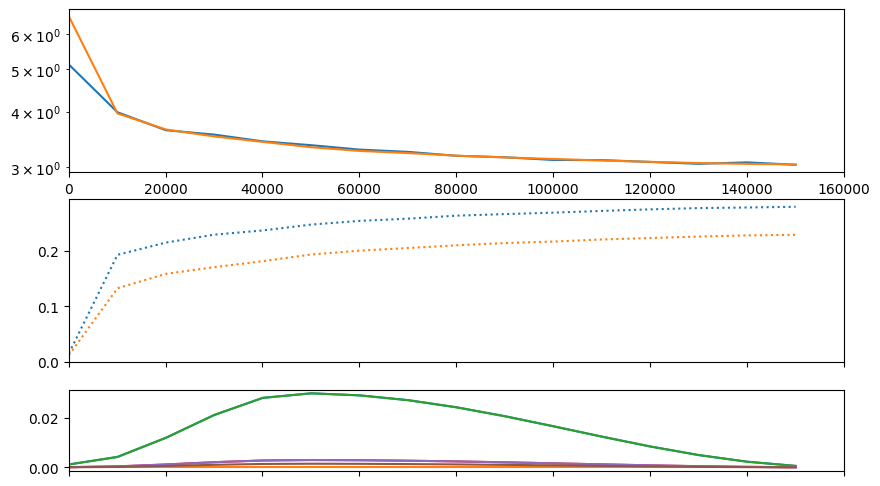

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads, EmbProj lr=10
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.35115,3.42734,04:18
100000,3.14926,3.16296,08:37
150016,3.03723,3.05682,12:56
160000,3.05514,3.04801,13:48


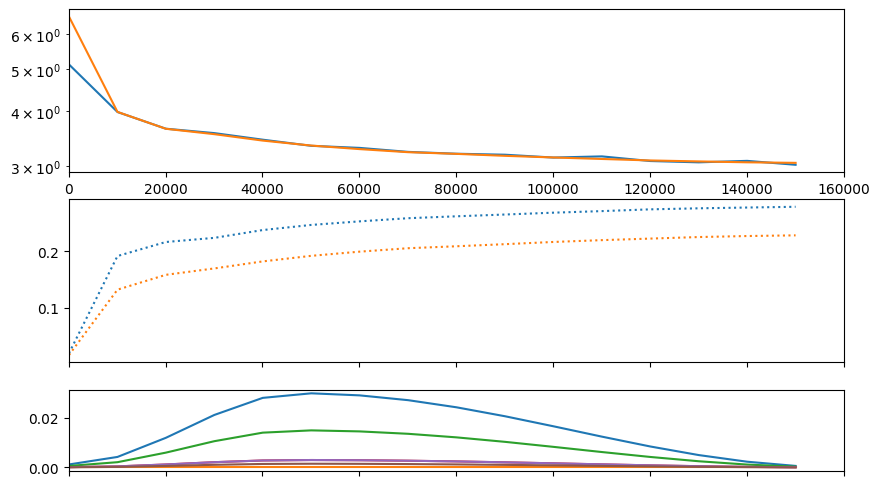

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads, EmbProj lr=5
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.43349,3.51735,04:18
100000,3.20685,3.21835,08:36
150016,3.14143,3.11906,12:54
160000,3.12234,3.11243,13:45


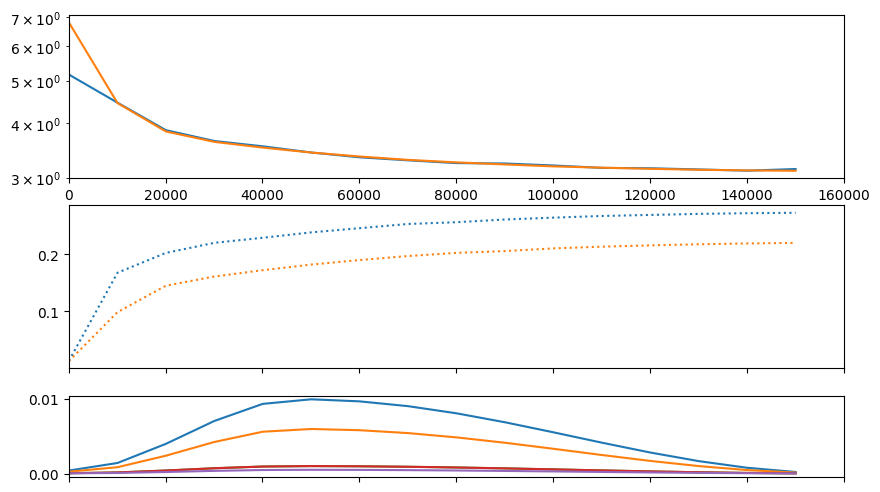

In [ ]:
# crossattn, emb 2Q, 400+ shards, linear heads
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=1e-3, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.73575,3.80450,05:12
100000,3.52139,3.51007,10:24
150016,3.38680,3.39870,15:36
160000,3.43426,3.39022,16:38


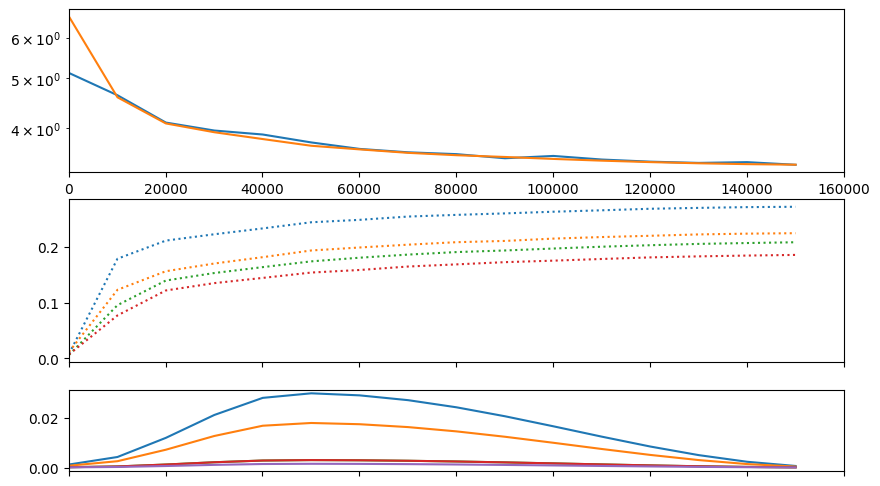

In [ ]:
# crossattn, emb 4Q, 400+ shards, linear heads
train_ds, val_ds = load_datasets('s2a-6454-4q/*.tar.gz', samples=160000)
model = make_model('micro', quantizers=4, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

384 32 4097


samples,train,val,time
50016,3.19818,3.27087,09:27
100000,2.94915,2.98427,18:55
150016,2.85464,2.87508,28:22
160000,2.82709,2.86586,30:15


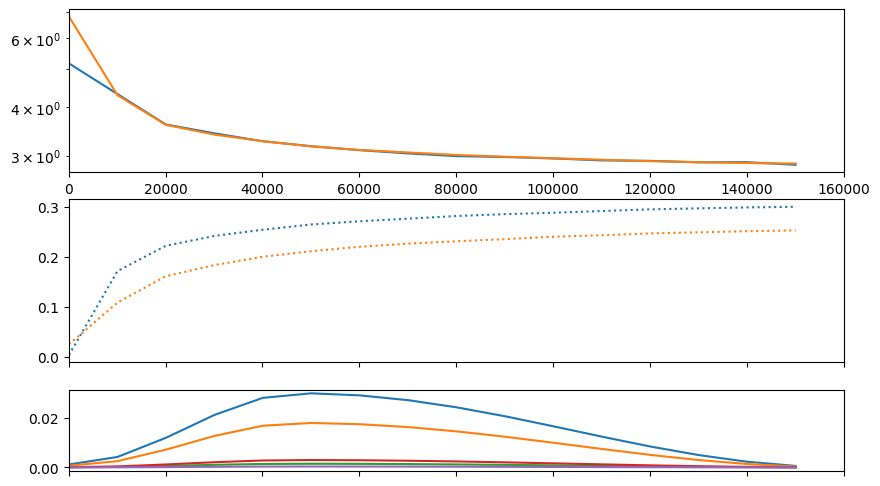

In [ ]:
# crossattn, emb 2Q
model = make_model('tiny', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-tiny-wds-cross.model')

384 64 513


samples,train,val,time
50016,3.09247,3.59736,09:29
100000,2.92941,3.28088,18:58
150016,2.87256,3.16761,28:27
200000,2.77072,3.07312,37:56
200928,2.80928,3.07167,38:18


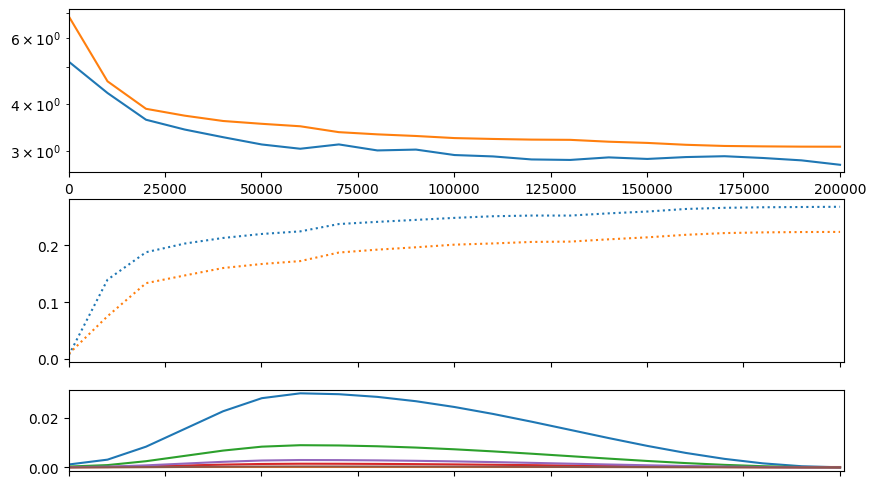

In [ ]:
train_ds, val_ds = load_datasets('whisperspeech-s2a-512c-dim64/*.tar.gz', samples=67000, stoks_pad_token=512)
model = make_model('tiny', quantizers=2, frozen_embeddings_model='vqmodel-256c-dim64-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=3, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-512c-dim64-tiny-wds-cross-6454.model')

384 32 513


samples,train,val,time
64,5.18270,0.00000,00:01


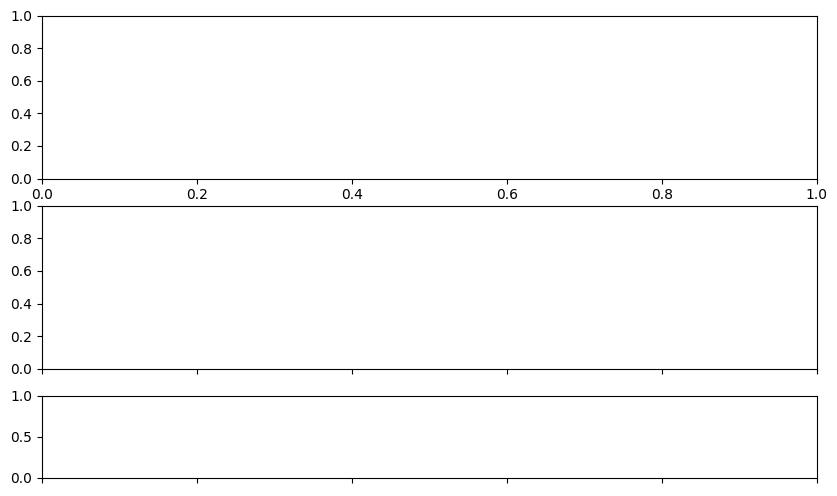

In [ ]:
train_ds, val_ds = load_datasets('whisperspeech-s2a-512c/*.tar.gz', samples=67000, stoks_pad_token=512)
model = make_model('tiny', quantizers=2, frozen_embeddings_model='vqmodel-256c-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=3, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-512c-tiny-wds-cross-6454.model')

384 32 4097


samples,train,val,time
50016,3.55823,3.63592,10:22
100000,3.24530,3.29306,20:43
150016,3.12748,3.16482,31:04
160000,3.15143,3.15668,33:08


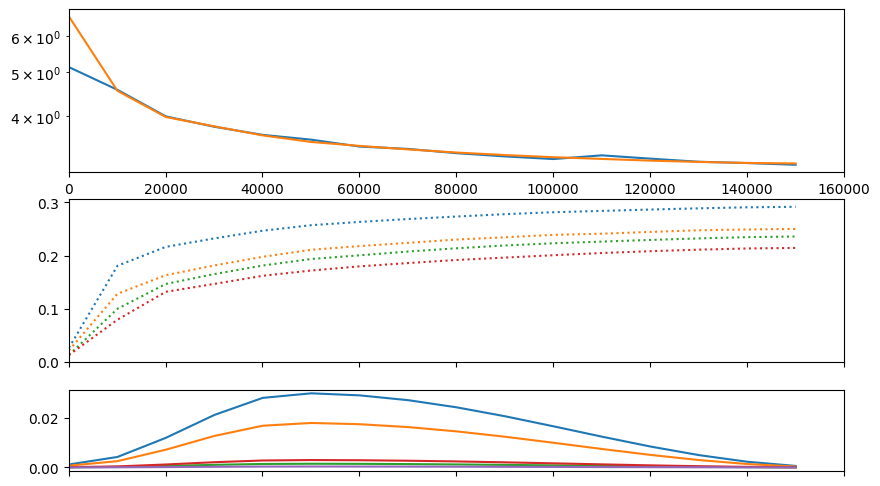

In [ ]:
# crossattn, emb 4Q, 400+ shards, linear heads
train_ds, val_ds = load_datasets('s2a-6454-4q/*.tar.gz', samples=160000)
model = make_model('tiny', quantizers=4, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds, tunables=Tunables(linear_heads=True)).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)
model.save_model('s2a-tiny-4q-wds-cross.model')

192 32 4097


samples,train,val,time
50016,4.38294,4.82997,03:52
100000,4.36976,4.85217,07:45
150016,4.48648,4.69173,11:37
160000,4.53327,4.65840,12:23


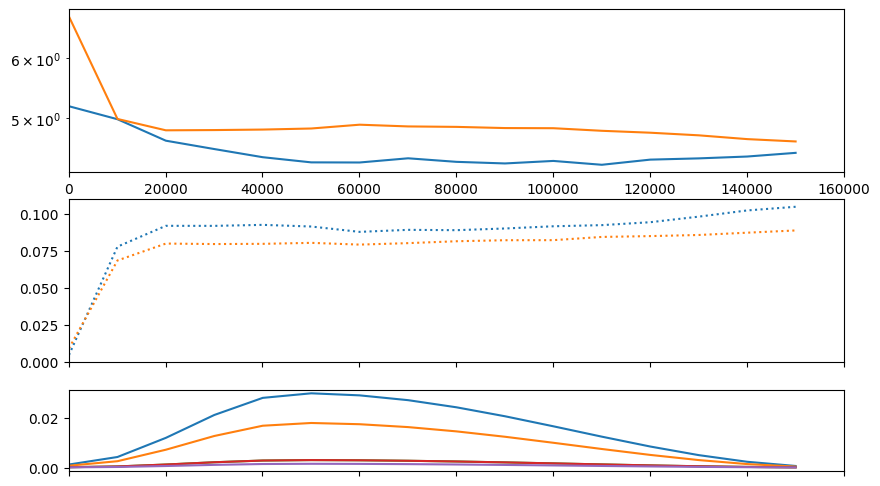

In [ ]:
# no xenc, emb 2Q
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.74297,4.20712,03:51
100000,3.65669,4.04836,07:42
150016,3.72150,3.91123,11:33
160000,3.74524,3.89218,12:19


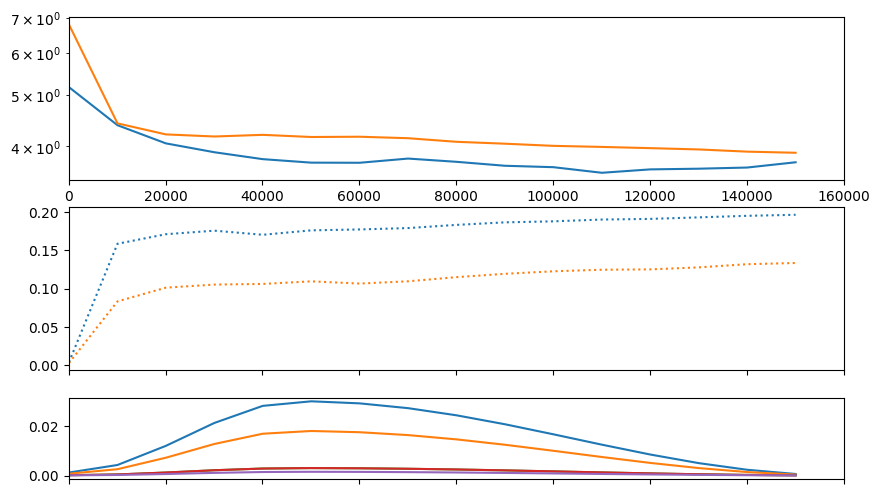

In [ ]:
# no xenc, emb 1Q
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.34288,4.00282,03:49
100000,3.27247,3.88112,07:38
150016,3.39283,3.73514,11:27
160000,3.46310,3.71837,12:13


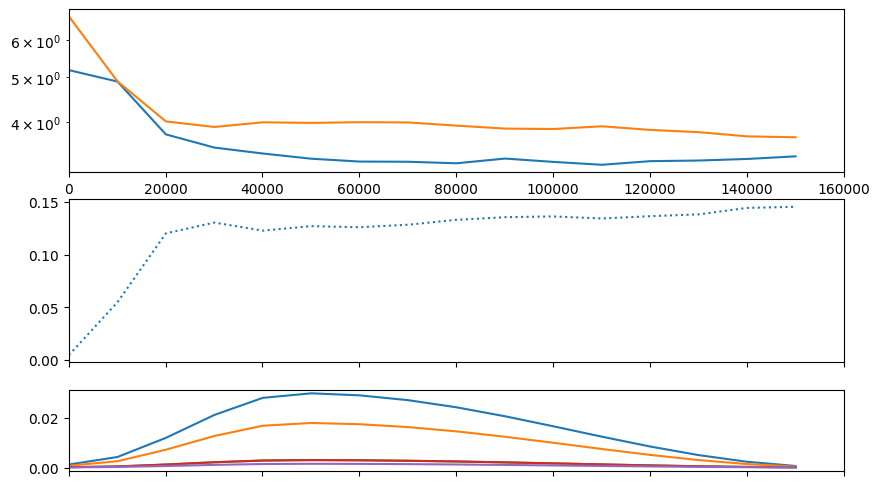

In [ ]:
# cross, 1q, don't embed Q1 ;)
model = make_model('micro', quantizers=1, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,2.86980,3.44263,03:50
100000,2.82082,3.44939,07:41
150016,3.00885,3.20670,11:32
160000,3.04030,3.16246,12:18


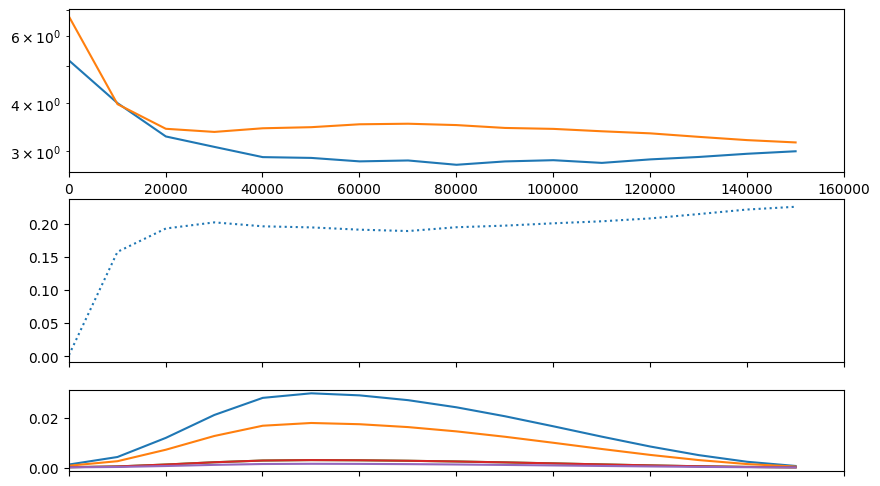

In [ ]:
# cross, 1q
model = make_model('micro', quantizers=1, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

192 32 4097


samples,train,val,time
50016,3.67311,4.19860,04:16
100000,3.67140,4.10176,08:31
150016,3.73631,3.94144,12:47
160000,3.73755,3.91028,13:38


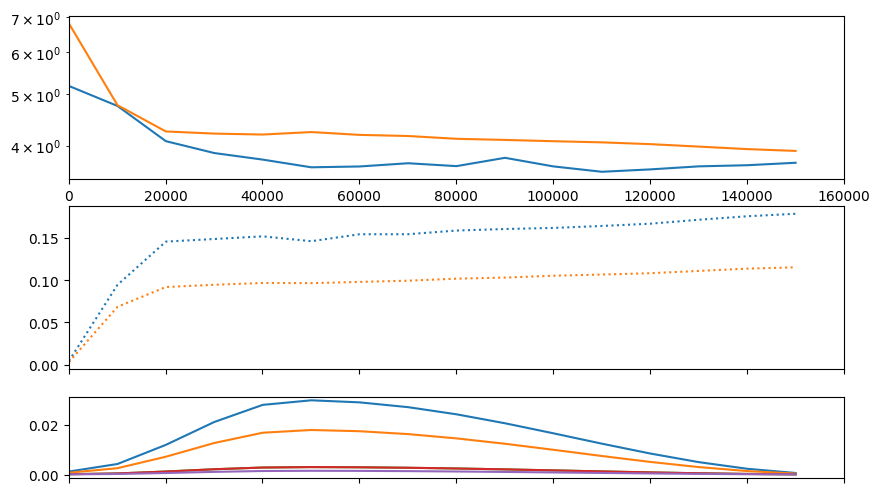

In [ ]:
# crossattn, emb 2Q (replace, not add)
model = make_model('micro', quantizers=2, frozen_embeddings_model='vqmodel-4e-hyptuned-32gpu.model', dataset=train_ds).cuda()
train(f"s2a-new", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=1, warmup_steps=model.tunables.warmup_steps,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

In [ ]:
s2a = make_model('base', quantizers=2, frozen_embeddings_model='vqmodel-512c-dim64-4e-hyptuned-32gpu.model', dataset=train_ds)
s2a.load_checkpoint('vital-dust-70.ckpt')
s2a.save_model('s2a-base-wds-cross-4e.model')

512 64 513
